# DeepFake Detection: VGG16 Model

**Objective**: Develop a base CNN model for DeepFake detection to use as baseline accuracy which can later be compared with other transfer learning models

**Base Models**: develop 2 types of base models:
1. CNN
2. Augementation + CNN Model

In [1]:
import numpy as np
% matplotlib inline
from __future__ import print_function

#Data Processing
from skimage import io
import os
import glob
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import random
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

#Neural Networks
from tensorflow.python import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras import optimizers

#Models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

#Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint,Callback
from keras.callbacks import ReduceLROnPlateau

from sklearn import metrics
from tensorflow.keras.models import load_model

Using TensorFlow backend.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mnt/disks/user/anaconda3/lib/python3.6/site-pa

## Dataset Split

Load the DeepFake dataset to randomly divide it into train and test set 

In [2]:
# path to your dataset
DATASET_PATH = '/mnt/disks/user/project/Dataset/'
deepfake_class = ['original/clean_frames','FaceSwap/clean_frames', 'Reenactment/clean_frames']

In [3]:
'''
func: load the deepfake dataset and divide them into train and test with each having samples of the different classes
input:
    i.dataset_path: string: the main dataset folder path 
    ii.train_ratio: float: the ratio of the dataset that will be used for training the model. Eg: 0.8
    iii. fake_class: string array: the different deepfake classes
output:
    i. train_set, test_set: dictionary of image paths as key and deepfake class as value
    ii. X_train, X_test: array of image paths 
    iii. y_train, y_test: array of corresponding deepfake classes 
'''
def MultiDatasetSplit(DATASET_PATH, train_ratio,fake_cls):
    test_set = {}
    train_set = {}
    list_IDs = []
    labels = {}
    for i, cls in enumerate(fake_cls):
        paths = glob.glob(os.path.join(DATASET_PATH, cls,'*/*.jpg'))
        #balancing the dataset
        balance_paths = random.sample(paths,2000)

        brk_point = int(len(balance_paths)*train_ratio)
        for j in range(len(balance_paths)):
            if j <= brk_point:
                train_set.update({balance_paths[j]:i})
            else:
                test_set.update({balance_paths[j]:i})
    
    X_train = [X for X in train_set.keys()] 
    y_train = [y for y in train_set.values()]
    X_test = [X for X in test_set.keys()]
    y_test = [y for y in test_set.values()]
    return train_set, test_set, X_train,y_train, X_test, y_test

In [4]:
'''
func: load the deepfake dataset and divide them into train and test with each having samples of the different classes
input:
    i.dataset_path: string: the main dataset folder path 
    ii.train_ratio: float: the ratio of the dataset that will be used for training the model. Eg: 0.8
    iii. fake_class: string array: the different deepfake classes
output:
    i. train_set, test_set: dictionary of image paths as key and deepfake class as value
    ii. X_train, X_test: array of image paths 
    iii. y_train, y_test: array of corresponding deepfake classes 
'''
def BinaryDatasetSplit(DATASET_PATH, train_ratio,fake_cls):
    test_set = {}
    train_set = {}
    list_IDs = []
    labels = {}
    for i, cls in enumerate(fake_cls):
        paths = glob.glob(os.path.join(DATASET_PATH, cls,'*/*.jpg'))
        if i == 0:
            paths = random.sample(paths,4000)
        else:
            paths = random.sample(paths,2000)
        brk_point = int(len(paths)*train_ratio)
        for j in range(len(paths)):
            if j <= brk_point:
                if i == 0:
                    train_set.update({paths[j]:0})
                else: 
                    train_set.update({paths[j]:1})
            else:
                if i == 0:
                    test_set.update({paths[j]:0})
                else:
                    test_set.update({paths[j]:1})

    X_train = [X for X in train_set.keys()] 
    y_train = [y for y in train_set.values()]
    X_test = [X for X in test_set.keys()]
    y_test = [y for y in test_set.values()]
    return train_set, test_set, X_train,y_train, X_test, y_test

In [5]:
b_train_set, b_test_set, b_train_X, b_train_y, b_test_X, b_test_y = BinaryDatasetSplit(DATASET_PATH,0.7,deepfake_class)

In [6]:
m_train_set, m_test_set, m_train_X, m_train_y, m_test_X, m_test_y = MultiDatasetSplit(DATASET_PATH,0.7,deepfake_class)

In [7]:
Counter(b_train_set.values())

Counter({0: 2801, 1: 2802})

In [8]:
Counter(m_train_set.values())

Counter({0: 1401, 1: 1401, 2: 1401})

In [9]:
set(b_test_set.values())

{0, 1}

In [10]:
set(m_test_set.values())

{0, 1, 2}

In [11]:
# specify image size and channels
img_channels = 3
img_rows = 224
img_cols = 224

# number of classes
b_nb_classes = 2
m_nb_classes = 3

## Data Processing

Divide data into batches and process them

In [12]:
'''
func: prepare and process batch wise data for training/ablation. 
The image path is converted to image data while the classes are label encoded (0,1,2)
input:
    i.image_list: X data: array of image paths
    ii:classes: y data: dictionary of image paths and their corresponding classes
output:
    i. DataGenerator
'''
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, image_list, classes, batch_size=32, dim=(224,224), n_channels=3,
                 n_classes=3,shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.classes = classes
        self.image_list = image_list
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_img_temp = [self.image_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_img_temp)
        return X, y


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_img_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization of Y
        y = np.empty((self.batch_size), dtype=int)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        #X = np.random.rand(self.batch_size, *self.dim, self.n_channels)

        #For each image path in the batch: load it, convert it to array, normalize values and pre-process.
        #Append X and respective y values to the empty X and y variables
        for i, ID in enumerate(list_img_temp):
            img = load_img(ID, target_size=self.dim)
            img = img_to_array(img)
            #img = img/255
            #process = datagen.fit(img)
            img = preprocess_input(img)
            X[i,] = img
            y[i] = self.classes[ID]
            
        #class encoding to 0,1,2
#         le = LabelEncoder()
#         self.y_value = le.fit_transform(y)
        return X,keras.utils.to_categorical(y, num_classes=self.n_classes)

In [13]:
'''
func: get the data generators for training and validation
input:
    i.train_X, test_X: array of image paths in training and testing respectively
    ii.train_set, test_set: dictionary of image paths and their corresponding class for training and test data respectively
    iii. ablation: int: number of training and test entries to use for DataGeneration
output:
    i. training_generator
    ii. validation_generator
'''
def data_generator(train_X, train_set, test_X, test_set,classes,ablation = None):
    #Randomly selecting data in case of ablation testing
    if ablation != None:
        train_X = random.sample(train_X, ablation)
        train_set = {image: train_set[image] for image in train_X }
        test_X = random.sample(test_X, ablation)
        test_set = {image: test_set[image] for image in test_X }
    print(Counter(test_set.values()))
    print(Counter(train_set.values()))
    training_generator = DataGenerator(train_X, train_set,n_classes=classes)
    validation_generator = DataGenerator(test_X, test_set,n_classes=classes)
    return training_generator,validation_generator

In [14]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

## VGG Feature Extractor

In [15]:
vgg_base = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg_base.layers[:fine_tune_at]:
    layer.trainable =  False

58892288/58889256 [==============================] - 5s 0us/step


## Binary VGG16 Classification Models

In [16]:
def cnn_model(in_shape=(224,224,3)):
    model = Sequential()
    model.add(vgg_base)
    model.add(Conv2D(64,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.6))
    model.add(Flatten())
    model.add(Dense(b_nb_classes, activation='sigmoid'))
    
    return model

#call define model
binary_vgg_model = cnn_model()
binary_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 64)          294976    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 15,011,714
Trainable params: 14,899,138
Non-trainable params: 112,576
__________________________________________________________

In [17]:
sgd = optimizers.SGD(lr=0.005, momentum=0.5, decay = 0.001)
# #reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2,
#                               patience=2, min_lr=0.0001)

In [18]:
training_generator, validation_generator = data_generator(b_train_X, b_train_set, b_test_X, b_test_set,classes=b_nb_classes)
binary_vgg_model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Counter({0: 1199, 1: 1198})
Counter({1: 2802, 0: 2801})


In [19]:
#validation_generator.classes.items()

In [20]:
# checkpoint 
binary_filepath = '/mnt/disks/user/project/Final_Models/vgg_binary_best_modelv2.hdf5'
checkpoint = ModelCheckpoint(binary_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()
# fit: this will fit the net on 'ablation' samples, only 1 epoch
binary_history = binary_vgg_model.fit_generator(generator = training_generator,
                    validation_data = validation_generator,
                    shuffle=True,
                    epochs=20,
                    callbacks=[checkpoint,auc_logger])

Epoch 1/20
174/175 [============================>.] - ETA: 1s - loss: 7.9587 - acc: 0.4998
Epoch 00001: val_acc improved from -inf to 0.50000, saving model to /mnt/disks/user/project/Final_Models/vgg_binary_best_modelv2.hdf5

Val AUC for epoch0: 0.5
175/175 [==============================] - 292s 2s/step - loss: 7.9588 - acc: 0.4998 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/20
174/175 [============================>.] - ETA: 0s - loss: 7.9684 - acc: 0.5002
Epoch 00002: val_acc did not improve from 0.50000

Val AUC for epoch1: 0.5
175/175 [==============================] - 158s 904ms/step - loss: 7.9684 - acc: 0.5002 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/20
174/175 [============================>.] - ETA: 0s - loss: 7.9591 - acc: 0.5025
Epoch 00003: val_acc did not improve from 0.50000

Val AUC for epoch2: 0.5
175/175 [==============================] - 158s 902ms/step - loss: 7.9451 - acc: 0.5034 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 4/20
174/175 [==========================

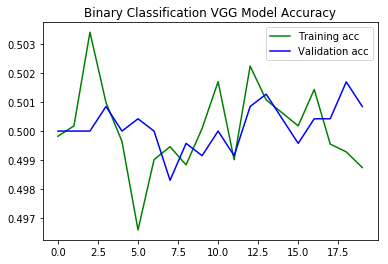

In [21]:
binary_acc = binary_history.history['acc']
binary_val_acc = binary_history.history['val_acc']

binary_epochs = range(len(binary_acc))

plt.plot(binary_epochs, binary_acc, 'g', label='Training acc')
plt.plot(binary_epochs, binary_val_acc, 'b', label='Validation acc')
plt.title('Binary Classification VGG Model Accuracy')
plt.legend()

### Hyperparameter Tuning

In [22]:
# # generic way to create custom callback
# class LossHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []

#     def on_batch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))

In [23]:
# # range of learning rates to tune
# hyper_parameters_for_lr = [0.1, 0.01, 0.001, 0.0001]

# # callback to append loss
# class LossHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []

#     def on_epoch_end(self, epoch, logs={}):
#         self.losses.append(logs.get('loss'))

# # instantiate a LossHistory() object to store histories
# history = LossHistory()
# plot_data = {}

# # for each hyperparam: train the model and plot loss history
# for lr in hyper_parameters_for_lr:
#     print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
#     sgd = optimizers.SGD(lr=lr, clipnorm=1.)
    
#     # model and generators
#     model_tuning = cnn_model()
#     model_tuning.compile(loss='categorical_crossentropy',optimizer= sgd,
#                   metrics=['accuracy'])
#     training_generator, validation_generator = data_generator(b_train_X, b_train_set, b_test_X, b_test_set,classes=b_nb_classes,ablation=100)
#     model_tuning.fit_generator(generator=training_generator,
#                         validation_data=validation_generator,
#                         epochs=3, callbacks=[history])
    
#     # plot loss history
#     plot_data[lr] = history.losses

In [24]:
# # plot loss history for each value of hyperparameter
# f, axes = plt.subplots(1, 4, sharey=True)
# f.set_figwidth(15)

# plt.setp(axes, xticks=np.arange(0, len(plot_data[0.01]), 1)+1)

# for i, lr in enumerate(plot_data.keys()):
#     axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

In [25]:
# # Utility function for obtaining of the errors 
# def obtain_errors(val_generator, predictions):
#     # Get the filenames from the generator
#     fnames = validation_generator.filenames

#     # Get the ground truth from generator
#     ground_truth = validation_generator.classes

#     # Get the dictionary of classes
#     label2index = validation_generator.class_indices

#     # Obtain the list of the classes
#     idx2label = list(label2index.keys())
#     print("The list of classes: ", idx2label)

#     # Get the class index
#     predicted_classes = np.argmax(predictions, axis=1)

#     errors = np.where(predicted_classes != ground_truth)[0]
#     print("Number of errors = {}/{}".format(len(errors),validation_generator.samples))
    
#     return idx2label, errors, fnames


# # Utility function for visualization of the errors
# def show_errors(idx2label, errors, predictions, fnames):
#     # Show the errors
#     for i in range(len(errors)):
#         pred_class = np.argmax(predictions[errors[i]])
#         pred_label = idx2label[pred_class]

#         title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
#             fnames[errors[i]].split('/')[0],
#             pred_label,
#             predictions[errors[i]][pred_class])

#         original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
#         plt.figure(figsize=[7,7])
#         plt.axis('off')
#         plt.title(title)
#         plt.imshow(original)
#         plt.show()

### Binary Base Model Evaluation

In [26]:
# test_X = random.sample(b_test_X, 100)
# test_set = {image: b_test_set[image] for image in test_X }

In [27]:
len(test_set)

NameError: name 'test_set' is not defined

In [28]:
binary_test_generator = DataGenerator(b_test_X, b_test_set,n_classes=2,shuffle=False)

In [29]:
#Load the best model
binary_eval_base_model = load_model(binary_filepath)
#binary_eval_base_model = load_model('/mnt/disks/user/project/Final_Models/res_binary_best_modelv2_val65.hdf5')

In [30]:
#x,y = binary_test_generator[0]

In [31]:
binary_predictions = binary_eval_base_model.predict_generator(binary_test_generator)
#binary_predictions = binary_res_model.predict_generator(binary_test_generator)
#binary_predictions = binary_eval_base_model.predict(binary_test_generator)

In [32]:
np.array(list(binary_test_generator.classes.values()))[binary_test_generator.indexes]

array([0, 0, 0, ..., 1, 1, 1])

In [33]:
np.array(list(binary_test_generator.classes.values()))[:len(binary_predictions)]

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
binary_y_class = np.array(list(binary_test_generator.classes.values()))[:len(binary_predictions)]
binary_y = keras.utils.to_categorical(binary_y_class, num_classes=b_nb_classes)

In [35]:
binary_prob_max = binary_predictions.max(axis=1).reshape(-1, 1)
binary_y_pred = np.where(binary_predictions == binary_prob_max, 1, 0)

In [36]:
binary_pred = np.argmax(binary_predictions, axis=-1)

In [37]:
len(binary_y_pred)

2368

In [38]:
len(binary_y)

2368

In [39]:
binary_y_class

array([0, 0, 0, ..., 1, 1, 1])

In [40]:
binary_pred

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
Counter(binary_pred)

Counter({0: 2368})

In [42]:
binary_score_test = metrics.accuracy_score(binary_y, binary_y_pred)
print('VGG Model Test Score ',binary_score_test)

VGG Model Test Score  0.5063344594594594


In [43]:
binary_cm = confusion_matrix(binary_y_class, binary_pred)
print(binary_cm)

[[1199    0]
 [1169    0]]


In [44]:
binary_report = classification_report(binary_y,binary_y_pred)
print(binary_report)

             precision    recall  f1-score   support

          0       0.51      1.00      0.67      1199
          1       0.00      0.00      0.00      1169

avg / total       0.26      0.51      0.34      2368



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
roc_auc_score(binary_y, binary_y_pred)

0.5

## Multi-Class VGG16 Classification Models

In [46]:
def cnn_model(in_shape=(224,224,3)):
    model = Sequential()
    model.add(vgg_base)
    model.add(Conv2D(64,(3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.6))
#     model.add(Conv2D(64,(3,3),strides=(2,2), padding='same'))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(m_nb_classes, activation='softmax'))
    
    return model

#call define model
multi_vgg_model = cnn_model()
multi_vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          294976    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 15,012,739
Trainable params: 14,900,163
Non-trainable params: 112,576
__________________________________________________________

In [47]:
sgd = optimizers.SGD(lr=0.005, momentum=0.5, decay = 0.001)

In [48]:
m_training_generator, m_validation_generator = data_generator(m_train_X, m_train_set, m_test_X, m_test_set,classes=m_nb_classes)
multi_vgg_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Counter({0: 599, 1: 599, 2: 599})
Counter({0: 1401, 1: 1401, 2: 1401})


In [49]:
# checkpoint 
multi_filepath = '/mnt/disks/user/project/Final_Models/multi_vgg_best_model.hdf5'
checkpoint = ModelCheckpoint(multi_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()
# fit: this will fit the net on 'ablation' samples, only 1 epoch
multi_history = multi_vgg_model.fit_generator(generator = m_training_generator,
                    validation_data = m_validation_generator,
                    shuffle=True,
                    epochs=20,
                    callbacks=[checkpoint])

Epoch 1/20
130/131 [============================>.] - ETA: 0s - loss: 10.5736 - acc: 0.3440
Epoch 00001: val_acc improved from -inf to 0.33259, saving model to /mnt/disks/user/project/Final_Models/multi_vgg_best_model.hdf5
131/131 [==============================] - 153s 1s/step - loss: 10.5775 - acc: 0.3438 - val_loss: 10.7574 - val_acc: 0.3326
Epoch 2/20
130/131 [============================>.] - ETA: 0s - loss: 10.7557 - acc: 0.3327
Epoch 00002: val_acc did not improve from 0.33259
131/131 [==============================] - 99s 753ms/step - loss: 10.7467 - acc: 0.3333 - val_loss: 10.7574 - val_acc: 0.3326
Epoch 3/20
130/131 [============================>.] - ETA: 0s - loss: 10.7364 - acc: 0.3339
Epoch 00003: val_acc improved from 0.33259 to 0.33315, saving model to /mnt/disks/user/project/Final_Models/multi_vgg_best_model.hdf5
131/131 [==============================] - 99s 758ms/step - loss: 10.7313 - acc: 0.3342 - val_loss: 10.7484 - val_acc: 0.3331
Epoch 4/20
130/131 [=============

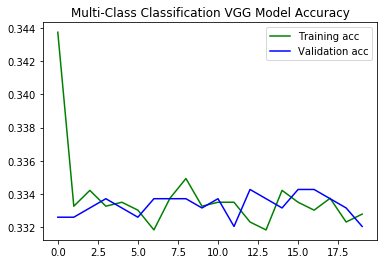

In [50]:
multi_acc = multi_history.history['acc']
multi_val_acc = multi_history.history['val_acc']

multi_epochs = range(len(multi_acc))

plt.plot(multi_epochs, multi_acc, 'g', label='Training acc')
plt.plot(multi_epochs, multi_val_acc, 'b', label='Validation acc')
plt.title('Multi-Class Classification VGG Model Accuracy')
plt.legend()

### Multi-Class Base Model Evaluation

In [51]:
multi_test_generator = DataGenerator(m_test_X, m_test_set,n_classes=m_nb_classes,shuffle=False)

In [52]:
#Load the best model
multi_eval_base_model = load_model(multi_filepath)

In [53]:
multi_predictions = multi_eval_base_model.predict_generator(multi_test_generator)

In [54]:
multi_y_class = np.array(list(multi_test_generator.classes.values()))[:len(multi_predictions)]
multi_y = keras.utils.to_categorical(multi_y_class, num_classes=m_nb_classes)

In [55]:
multi_prob_max = multi_predictions.max(axis=1).reshape(-1, 1)
multi_y_pred = np.where(multi_predictions == multi_prob_max, 1, 0)

In [56]:
multi_pred = np.argmax(multi_predictions, axis=-1)

In [57]:
len(multi_y_pred)

1792

In [58]:
len(multi_y)

1792

In [59]:
Counter(multi_pred)

Counter({1: 1792})

In [60]:
multi_score_test = metrics.accuracy_score(multi_y, multi_y_pred)
print('Multi-Class VGG Model Test Score ',multi_score_test)

Multi-Class VGG Model Test Score  0.33426339285714285


In [61]:
multi_cm = confusion_matrix(multi_y_class, multi_pred)
print(multi_cm)

[[  0 599   0]
 [  0 599   0]
 [  0 594   0]]


In [62]:
multi_report = classification_report(multi_y,multi_y_pred)
print(multi_report)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       599
          1       0.33      1.00      0.50       599
          2       0.00      0.00      0.00       594

avg / total       0.11      0.33      0.17      1792



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
